# Introduction

pytorch is good

# motivation

He said this tutorial is comprehensive. lets see.

Pytorch is complete with autograd, dynamic computation graph, model classes etc

Lets go.

# Simple regression Problem

This part is to show you how pytorch work.

That's why this part is so simple.

## Data generation

Let's try generate data randomly here.

We know a =1  and b =2

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

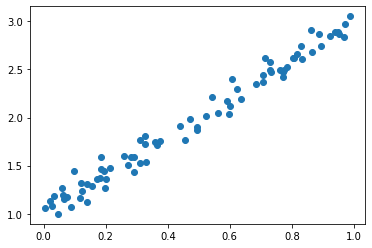

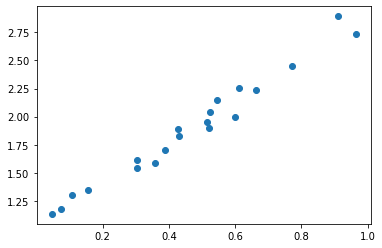

In [6]:
plt.scatter(x_train, y_train)
plt.show()

plt.scatter(x_val, y_val)
plt.show()

# Gradient Descent
## 1. compute loss

For this problem we use MSE

note : batch is N, 1 is stochastic, in between is mini-batch gradient descent

## 2. compute gradient descent

we partial derivative for every weight

it tells how much the weight affect the result

there is math formula for that.


## 3. Update the parameter.

since we want to minimize the loss then we have to reduce the variable(a and b) according to gradient descent

## 4. repeat

repeat for many epoch

note :  1 epoch equal 1 iterartion until all point used. if its bacth then 1 batch is 1 epoch, if it is stochastic then until N is 1 epoch

# Linear regression in Numpy

First we try to implement using numpy for learning purpose.

this is the code

In [12]:

# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad
    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


It's good.

now next is pytorch

# Pytorch


[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.FloatTensor


In [10]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.3367], requires_grad=True) tensor([0.1288], requires_grad=True)


In [11]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients! 
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()
    
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    print(a.grad)
    print(b.grad)
    
    # What about UPDATING the parameters? Not so fast...
    
    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad        
    
    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad
    
    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()
    
print(a, b)

tensor([-3.1125])
tensor([-1.8156])
tensor([-2.3184])
tensor([-1.4064])
tensor([-1.7219])
tensor([-1.0982])
tensor([-1.2737])
tensor([-0.8659])
tensor([-0.9372])
tensor([-0.6906])
tensor([-0.6845])
tensor([-0.5583])
tensor([-0.4948])
tensor([-0.4582])
tensor([-0.3526])
tensor([-0.3824])
tensor([-0.2459])
tensor([-0.3248])
tensor([-0.1660])
tensor([-0.2810])
tensor([-0.1063])
tensor([-0.2475])
tensor([-0.0616])
tensor([-0.2218])
tensor([-0.0283])
tensor([-0.2019])
tensor([-0.0036])
tensor([-0.1864])
tensor([0.0147])
tensor([-0.1743])
tensor([0.0283])
tensor([-0.1646])
tensor([0.0382])
tensor([-0.1568])
tensor([0.0453])
tensor([-0.1505])
tensor([0.0505])
tensor([-0.1452])
tensor([0.0541])
tensor([-0.1408])
tensor([0.0566])
tensor([-0.1370])
tensor([0.0582])
tensor([-0.1337])
tensor([0.0592])
tensor([-0.1307])
tensor([0.0597])
tensor([-0.1280])
tensor([0.0599])
tensor([-0.1255])
tensor([0.0598])
tensor([-0.1232])
tensor([0.0594])
tensor([-0.1211])
tensor([0.0590])
tensor([-0.1190])
tensor

tensor([0.0007])
tensor([-0.0014])
tensor([0.0007])
tensor([-0.0013])
tensor([0.0007])
tensor([-0.0013])
tensor([0.0007])
tensor([-0.0013])
tensor([0.0007])
tensor([-0.0013])
tensor([0.0006])
tensor([-0.0013])
tensor([0.0006])
tensor([-0.0012])
tensor([0.0006])
tensor([-0.0012])
tensor([0.0006])
tensor([-0.0012])
tensor([0.0006])
tensor([-0.0012])
tensor([0.0006])
tensor([-0.0012])
tensor([0.0006])
tensor([-0.0012])
tensor([0.0006])
tensor([-0.0011])
tensor([0.0006])
tensor([-0.0011])
tensor([0.0006])
tensor([-0.0011])
tensor([0.0006])
tensor([-0.0011])
tensor([0.0005])
tensor([-0.0011])
tensor([0.0005])
tensor([-0.0011])
tensor([0.0005])
tensor([-0.0010])
tensor([0.0005])
tensor([-0.0010])
tensor([0.0005])
tensor([-0.0010])
tensor([0.0005])
tensor([-0.0010])
tensor([0.0005])
tensor([-0.0010])
tensor([0.0005])
tensor([-0.0010])
tensor([0.0005])
tensor([-0.0009])
tensor([0.0005])
tensor([-0.0009])
tensor([0.0005])
tensor([-0.0009])
tensor([0.0005])
tensor([-0.0009])
tensor([0.0005])
ten

tensor([1.1191e-05])
tensor([-2.1685e-05])
tensor([1.1090e-05])
tensor([-2.1328e-05])
tensor([1.0991e-05])
tensor([-2.0966e-05])
tensor([1.0841e-05])
tensor([-2.0638e-05])
tensor([1.0597e-05])
tensor([-2.0378e-05])
tensor([1.0381e-05])
tensor([-2.0099e-05])
tensor([1.0172e-05])
tensor([-1.9811e-05])
tensor([9.9134e-06])
tensor([-1.9561e-05])
tensor([9.8250e-06])
tensor([-1.9239e-05])
tensor([9.7390e-06])
tensor([-1.8921e-05])
tensor([9.5970e-06])
tensor([-1.8628e-05])
tensor([9.5194e-06])
tensor([-1.8312e-05])
tensor([9.2852e-06])
tensor([-1.8094e-05])
tensor([9.0717e-06])
tensor([-1.7856e-05])
tensor([8.8692e-06])
tensor([-1.7605e-05])
tensor([8.8958e-06])
tensor([-1.7261e-05])
tensor([8.7665e-06])
tensor([-1.7017e-05])
tensor([8.7046e-06])
tensor([-1.6718e-05])
tensor([8.5874e-06])
tensor([-1.6478e-05])
tensor([8.4943e-06])
tensor([-1.6209e-05])
tensor([8.4157e-06])
tensor([-1.5924e-05])
tensor([8.2179e-06])
tensor([-1.5733e-05])
tensor([8.0168e-06])
tensor([-1.5523e-05])
tensor([7.8

tensor([5.7620e-07])
tensor([-6.0361e-07])
tensor([6.7911e-07])
tensor([-5.3330e-07])
tensor([4.4022e-07])
tensor([-6.4343e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4640e-07])
tensor([-5.7230e-07])
tensor([5.4